## Outline
1. Define Task
2. Data Preprocessing
3. Build LSTM model
4. Model training & prediction
6. Testing & Result

## 1. Define Task

### Target Task
We will forecast electricity load demand for Jan-2020 based on Training dataset from 2015-2019 using different LSTM model and compare their accuracy.

## 2. Data Preprocessing

In [2]:
import os, pprint, time, matplotlib, torch
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from torchsummaryX import summary
from tqdm import tqdm

In [3]:
def remove_stock_split_days(dfs_dict):
    tgt_list = list(dfs_dict.keys())
    masked_index = dfs_dict[tgt_list[0]].index
    for i in range(1, len(tgt_list)):
        masked_index = masked_index.intersection(dfs_dict[tgt_list[i]].index)
    for i in range(len(tgt_list)):
        dfs_dict[tgt_list[i]] = dfs_dict[tgt_list[i]].loc[masked_index]
    return masked_index

def get_preprocessed_data_close_price(start, end, intv, company_index_list, company_name_list):
    ## compute target companies close price
    ticker_list = yf.Tickers(company_index_list)
    close_dict = {}
    for idx, name in zip(company_index_list, company_name_list):
        close_dict[name] = ticker_list.tickers[idx].history(start=start, end=end, interval=intv)['Close']

    masked_index = remove_stock_split_days(close_dict)
    print("\nAfter filtering out rows")
    for idx, name in zip(company_index_list, company_name_list):
        print(idx, name, close_dict[name].shape)
    close_final = pd.DataFrame(close_dict)
    print("[Final X] ", close_final.shape)

    mask_bool = np.invert(close_final.isnull().values.any(axis=1))
    close_final = close_final[mask_bool]

    ## compute QQQ close price
    qqq_price = 'QQQ'
    qqq_df = yf.Tickers(qqq_price).tickers[qqq_price].history(start=start, end=end, interval=intv)
    qqq_df = qqq_df.drop([c for c in qqq_df.columns if c != 'Close'], axis=1)
    qqq_df = qqq_df.loc[close_final.index]  ## remove the QQQ rows which are not in company info
    return close_final, qqq_df

def plot_close_price(close_final, qqq_df):
    plt.figure(figsize=(15,12))
    for c in close_final.columns:
        plt.plot(close_final[c], label=c)
    plt.plot(qqq_df, label='QQQ')
    plt.title('Trend of Close Price')
    #plt.xticks(rotation=100)
    plt.legend()
    plt.show()

In [4]:
start, end, intv = "2017-01-01", "2021-12-31", '1d'
stocks = ["AAPL","ADBE","AMZN","AVGO","FB","GOOG","GOOGL","MSFT","NVDA","TSLA"]
stocks_name = ['Apple', 'Adobe', 'Amazon', 'Broadcom', 'Facebook', 'Google-C', 'Google-A', 'Microsoft', 'Nvida', 'Tesla']
close_df, qqq_df = get_preprocessed_data_close_price(start, end, intv, stocks, stocks_name)



After filtering out rows
AAPL Apple (1258,)
ADBE Adobe (1258,)
AMZN Amazon (1258,)
AVGO Broadcom (1258,)
FB Facebook (1258,)
GOOG Google-C (1258,)
GOOGL Google-A (1258,)
MSFT Microsoft (1258,)
NVDA Nvida (1258,)
TSLA Tesla (1258,)
[Final X]  (1258, 10)


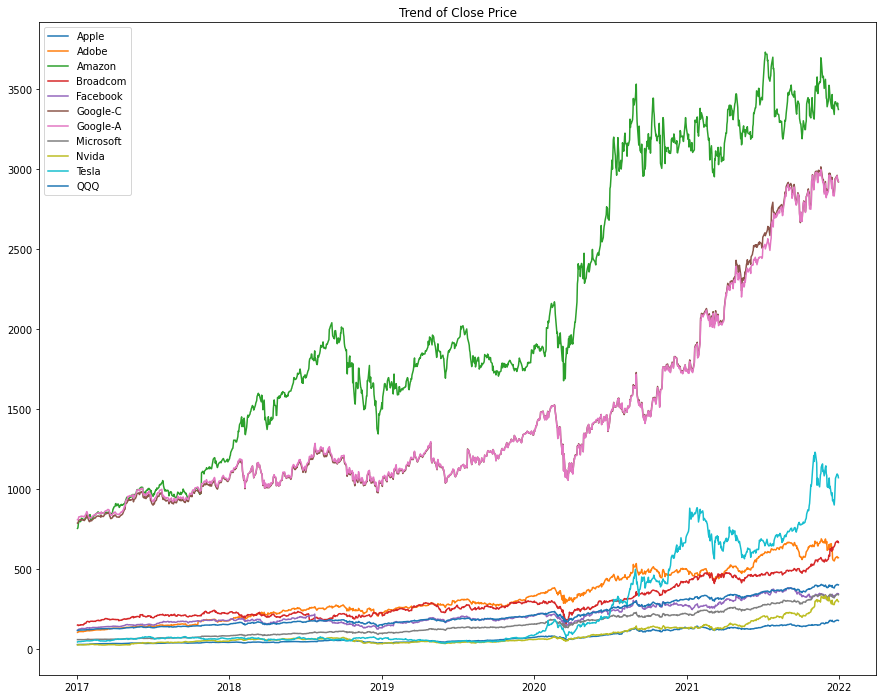

In [5]:
plot_close_price(close_df, qqq_df)

In [6]:
close_df

,Apple,Adobe,Amazon,Broadcom,Facebook,Google-C,Google-A,Microsoft,Nvida,Tesla
Date,,,,,,,,,,
2017-01-03,27.297691,103.480003,753.669983,149.425903,116.860001,786.140015,808.010010,58.065456,25.166449,43.397999
2017-01-04,27.267141,104.139999,757.179993,148.361771,118.690002,786.900024,807.770020,57.805656,25.753605,45.397999
2017-01-05,27.405800,105.910004,780.450012,146.024124,120.669998,794.020020,813.020020,57.805656,25.099838,45.349998
2017-01-06,27.711327,108.300003,795.989990,147.959610,123.410004,806.150024,825.210022,58.306702,25.435358,45.801998
2017-01-09,27.965149,108.570000,796.919983,148.278000,124.900002,806.650024,827.179993,58.121124,26.466583,46.256001
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,176.055695,569.619995,3421.370117,664.799988,335.239990,2942.850098,2938.330078,333.999390,296.349487,1067.000000
2021-12-27,180.100540,577.679993,3393.389893,674.280029,346.179993,2961.280029,2958.129883,341.743378,309.397308,1093.939941
2021-12-28,179.061859,569.359985,3413.219971,669.000000,346.220001,2928.959961,2933.739990,340.545837,303.168335,1088.469971


In [7]:
class PriceDataset(data.Dataset):
    def __init__(self, Xs, Ys, window_size):
        self.Xs = Xs
        self.Ys = Ys
        self.window_size = window_size

    def __getitem__(self, idx):
        xs = self.Xs[idx:idx + self.window_size]
        y = self.Ys[idx + self.window_size]
        return torch.tensor(xs, dtype=torch.float), torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.Ys) - self.window_size

    def scaling(self, mean, std):
        self.Ys = (self.Ys - mean) / std
        self.mean = mean
        self.std = std


In [8]:
window_size = 5
train_split_ratio = 0.8

## split train and val set
Xs, Ys = close_df.values, qqq_df.values
num_train_row = int(len(Xs) * train_split_ratio)
Xs_train, Ys_train = Xs[:num_train_row], Ys[:num_train_row]
Xs_val, Ys_val = Xs[num_train_row:], Ys[num_train_row:]
print(Ys_train.shape, Ys_val.shape)

train_set = PriceDataset(Xs_train, Ys_train, window_size)
val_set = PriceDataset(Xs_val, Ys_val, window_size)
train_mean = train_set.Ys.mean()
train_std = train_set.Ys.std()
train_set.scaling(train_mean, train_std)
val_set.scaling(train_mean, train_std)
print("[Size] Train_Set: {} | Val_Set: {}".format(len(train_set), len(val_set)))


(1006, 1) (252, 1)
[Size] Train_Set: 1001 | Val_Set: 247


In [14]:
train_set.Xs 

array([[  27.29769135,  103.48000336,  753.66998291, ...,   58.06545639,
          25.16644859,   43.39799881],
       [  27.26714134,  104.13999939,  757.17999268, ...,   57.80565643,
          25.75360489,   45.39799881],
       [  27.40579987,  105.91000366,  780.45001221, ...,   57.80565643,
          25.09983826,   45.34999847],
       ...,
       [ 135.67964172,  498.95001221, 3283.95996094, ...,  222.62965393,
         128.86549377,  663.69000244],
       [ 133.87307739,  502.10998535, 3322.        , ...,  221.82804871,
         129.29751587,  665.98999023],
       [ 132.73158264,  497.45001221, 3285.85009766, ...,  219.38363647,
         131.32040405,  694.7800293 ]])

## 3. Build LSTM model

In [9]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMNet, self).__init__()
        self.norm1 = nn.BatchNorm1d(input_size) # [n_batch, input_size]
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True, 
        )
        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, Xs): # Xs : [n_batch, window_size, input_size]
        Xs = self.norm1(Xs.flatten(0, 1)).reshape(Xs.shape) #  batchnorm1d([n_batch * window_size, input_size]) => reshape into [n_batch, window_size, input_size]
        rnn_out, _ = self.lstm(Xs) # rnn_out: [n_batch, window_size, hidden_size]
        ## torch.sum(rnn_out, dim=1) # [n_batch, hidden_size]
        out = self.regressor(rnn_out[:, -1]) # batch first
        return out

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size, hidden_size, num_layers, dropout = 10, 64, 2, 0.2
lstm_net = LSTMNet(input_size, hidden_size, num_layers, dropout)
lstm_net.to(device)
summary(lstm_net, torch.rand(4, 10, 10).to(device))


            Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                   
0_norm1             [10]     [40, 10]      20         10
1_lstm                 -  [4, 10, 64]   52736      51712
2_regressor      [64, 1]       [4, 1]      65         64
--------------------------------------------------------
                      Totals
Total params           52821
Trainable params       52821
Non-trainable params       0
Mult-Adds              51786


/opt/anaconda3/lib/python3.9/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_norm1,[10],"[40, 10]",20,10
1_lstm,-,"[4, 10, 64]",52736,51712
2_regressor,"[64, 1]","[4, 1]",65,64


In [11]:
def train_epoch(net, optimizer, loss_fn, dataloader, epoch, writer=None, device='cpu'):
    ep_loss = 0.0
    num_iter = len(dataloader)
    net.train()
    grad_max = 100.
    for n_iter, (xs, y) in enumerate(tqdm(dataloader)):
        curr_iter = epoch * num_iter + n_iter
        xs, y = xs.to(device), y.to(device)
        pred = net(xs) ## step 1. get output
        loss = loss_fn(pred, y) ## step 2. compute loss
        optimizer.zero_grad()
        loss.backward() ## step 3. backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), grad_max) ## L2-norm gradient clipping
        optimizer.step() ## step 4. update model weigth
        if writer is not None:
            writer.add_scalar('Loss/train', loss.data, curr_iter)
        # print("\n[ITER %d] LOSS: %.4f" % (curr_iter, loss.data))
        ep_loss += loss.data
    ep_loss /= len(dataloader)
    if writer is not None:
        writer.add_scalar('EpLoss/train', ep_loss, epoch)
    print("\n[EP %d] Train LOSS: %.4f" % (epoch, ep_loss))
    return ep_loss

@torch.no_grad()
def val_epoch(net, loss_fn, dataloader, epoch, val_set, writer=None, device='cpu'):
    ep_loss = 0.0
    net.eval()
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(tqdm(dataloader)):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
        preds.append(pred.squeeze())
        ys.append(y)
    ep_loss /= len(dataloader)
    print("\n[EP %d] Val LOSS: %.4f" % (epoch, ep_loss))

    preds = torch.stack(preds).squeeze()
    ys = torch.stack(ys).squeeze()
    # if (epoch + 1) % 5 == 0:
    ## denormalize
    preds = preds * val_set.std + val_set.mean
    ys = ys * val_set.std + val_set.mean

    ## plot the prediction and GT close value
    plt.plot(ys.cpu().numpy(), label='GT')
    plt.plot(preds.cpu().numpy(), label='pred')
    plt.title("[Ep %d] GT vs Pred"%(epoch))
    plt.legend()
    plt.show()

    if writer is not None:
        writer.add_scalar('EpLoss/val', ep_loss, epoch)
    return ep_loss

def train_main(net, train_set, val_set, loss_fn, batch_size, lr, n_epoch):
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = data.DataLoader(val_set, batch_size=1)

    writer = None
    save_dir = './'
    # writer = SummaryWriter(log_dir=osp.join(save_dir, 'log'))
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    train_ep_losses, val_ep_losses = [], []
    for epoch in range(n_epoch):
        train_loss = train_epoch(net, optimizer, loss_fn, train_loader, epoch, writer, device)
        val_loss = val_epoch(net, loss_fn, val_loader, epoch, val_set, writer, device)
        train_ep_losses.append(train_loss)
        val_ep_losses.append(val_loss)
        if (epoch + 1) % 5 == 0:
            os.makedirs(osp.join(save_dir, 'weights'), exist_ok=True)
            torch.save(net.state_dict(), osp.join(save_dir, 'weights/ep%d.pth' % (epoch + 1)))
    
    plt.plot(torch.tensor(train_ep_losses).cpu().numpy(), label='train')
    plt.plot(torch.tensor(val_ep_losses).cpu().numpy(), label='val')
    plt.xlabel('n_epoch')
    plt.legend()
    plt.show()

## 4. Model Training & prediction

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 251.08it/s]



[EP 0] Train LOSS: 0.3342


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3706.82it/s]



[EP 0] Val LOSS: 1.7134


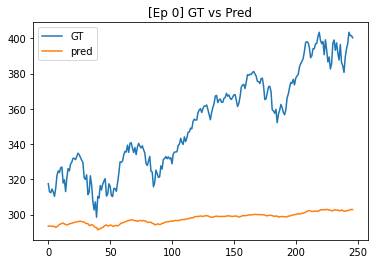

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 299.35it/s]



[EP 1] Train LOSS: 0.0529


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3268.61it/s]



[EP 1] Val LOSS: 2.2283


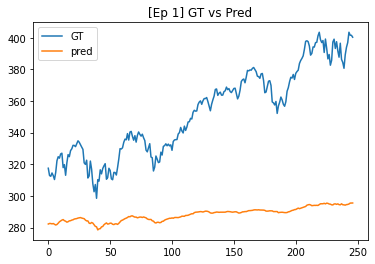

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.07it/s]



[EP 2] Train LOSS: 0.0436


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 1994.67it/s]


[EP 2] Val LOSS: 1.6827


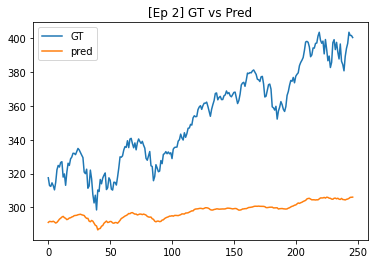

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 299.55it/s]



[EP 3] Train LOSS: 0.0434


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3304.00it/s]



[EP 3] Val LOSS: 1.5317


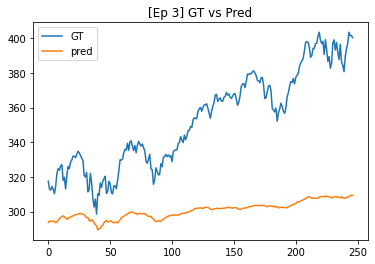

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 296.81it/s]



[EP 4] Train LOSS: 0.0524


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3307.40it/s]



[EP 4] Val LOSS: 1.4222


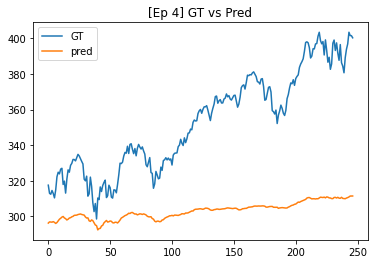

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.72it/s]



[EP 5] Train LOSS: 0.0548


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3315.03it/s]



[EP 5] Val LOSS: 1.6739


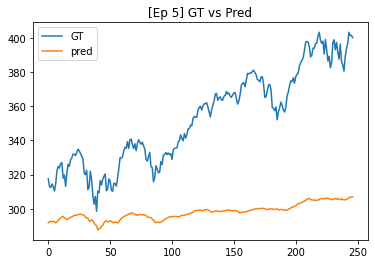

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 296.06it/s]



[EP 6] Train LOSS: 0.0481


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3309.98it/s]



[EP 6] Val LOSS: 1.6760


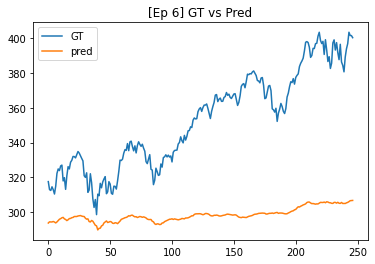

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 305.49it/s]



[EP 7] Train LOSS: 0.0649


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3508.72it/s]



[EP 7] Val LOSS: 1.3402


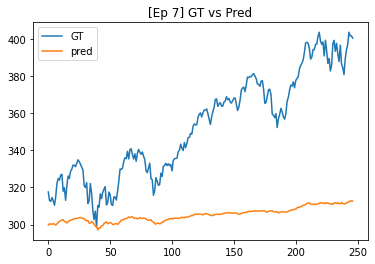

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 295.48it/s]



[EP 8] Train LOSS: 0.0486


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3316.24it/s]



[EP 8] Val LOSS: 1.4622


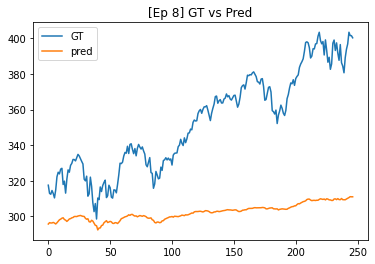

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.14it/s]



[EP 9] Train LOSS: 0.0471


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3305.10it/s]



[EP 9] Val LOSS: 1.3462


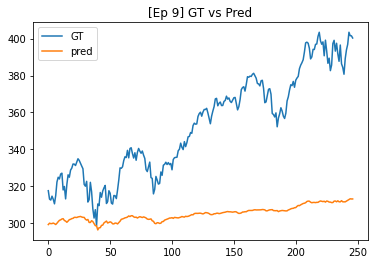

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.99it/s]



[EP 10] Train LOSS: 0.0421


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3457.54it/s]



[EP 10] Val LOSS: 1.5128


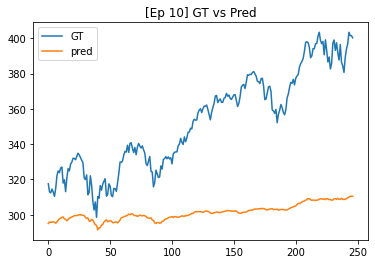

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.66it/s]



[EP 11] Train LOSS: 0.0447


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3536.36it/s]



[EP 11] Val LOSS: 1.3427


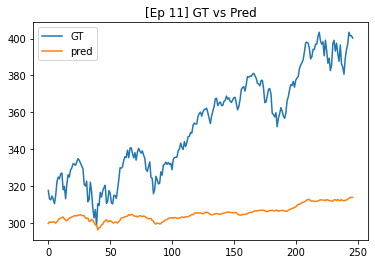

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 297.21it/s]



[EP 12] Train LOSS: 0.0577


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2932.06it/s]



[EP 12] Val LOSS: 1.6647


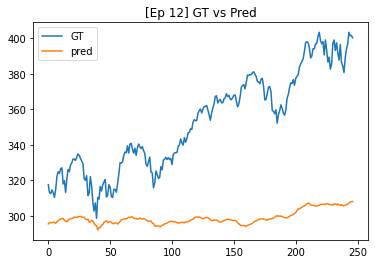

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 297.53it/s]



[EP 13] Train LOSS: 0.0533


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3503.59it/s]



[EP 13] Val LOSS: 1.1121


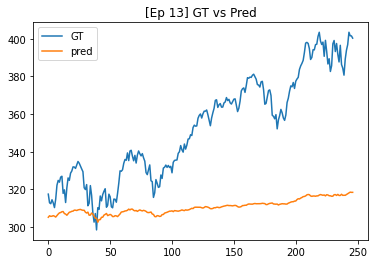

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 296.25it/s]



[EP 14] Train LOSS: 0.0556


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3446.97it/s]



[EP 14] Val LOSS: 1.3704


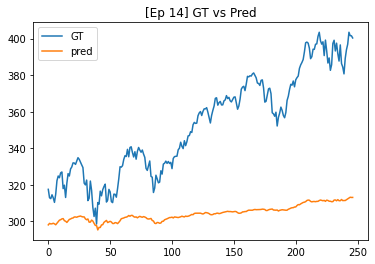

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 305.78it/s]



[EP 15] Train LOSS: 0.0388


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3460.83it/s]



[EP 15] Val LOSS: 1.6512


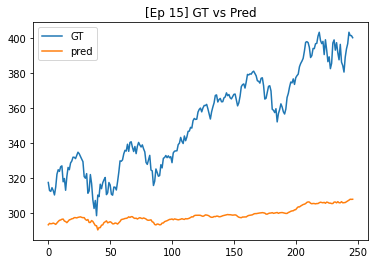

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 306.25it/s]



[EP 16] Train LOSS: 0.0545


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3710.79it/s]



[EP 16] Val LOSS: 1.4455


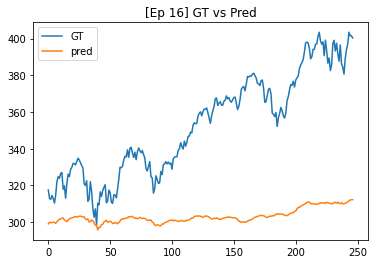

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.17it/s]



[EP 17] Train LOSS: 0.0502


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3440.08it/s]



[EP 17] Val LOSS: 1.1030


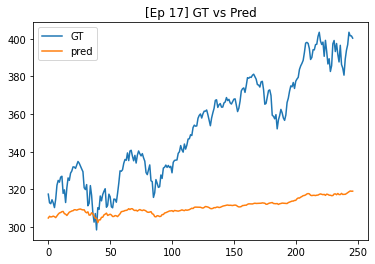

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 315.23it/s]



[EP 18] Train LOSS: 0.0326


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2081.30it/s]


[EP 18] Val LOSS: 1.5297


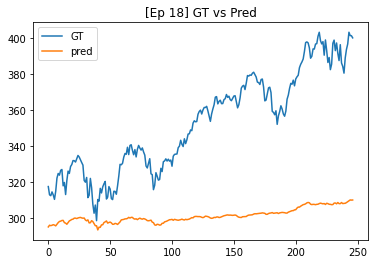

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 299.99it/s]



[EP 19] Train LOSS: 0.0532


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3380.75it/s]



[EP 19] Val LOSS: 1.6975


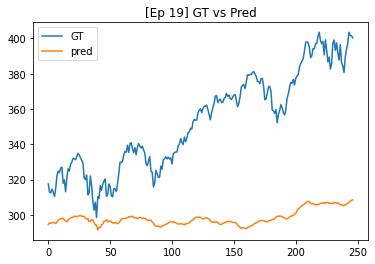

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 305.62it/s]



[EP 20] Train LOSS: 0.0481


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3468.82it/s]



[EP 20] Val LOSS: 1.4604


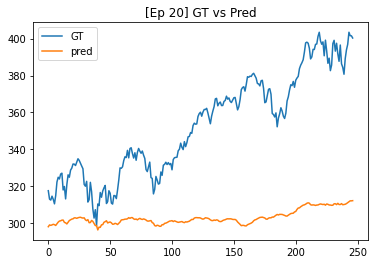

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 306.05it/s]



[EP 21] Train LOSS: 0.0478


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3541.78it/s]



[EP 21] Val LOSS: 1.2867


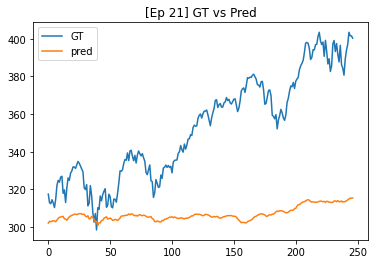

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 305.95it/s]



[EP 22] Train LOSS: 0.0401


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3670.09it/s]



[EP 22] Val LOSS: 1.2848


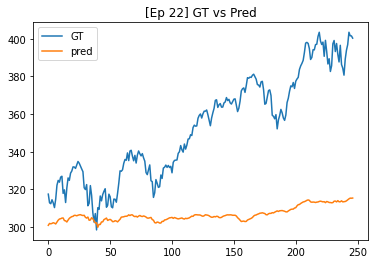

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.54it/s]



[EP 23] Train LOSS: 0.0340


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3463.06it/s]



[EP 23] Val LOSS: 1.6012


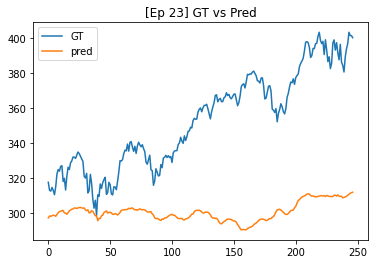

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 275.95it/s]



[EP 24] Train LOSS: 0.0536


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3214.31it/s]



[EP 24] Val LOSS: 1.6594


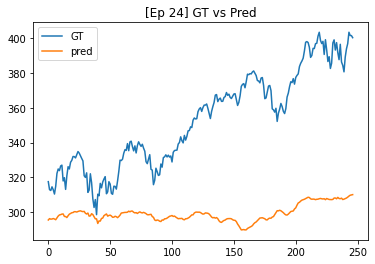

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 296.46it/s]



[EP 25] Train LOSS: 0.0334


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3358.90it/s]



[EP 25] Val LOSS: 1.3575


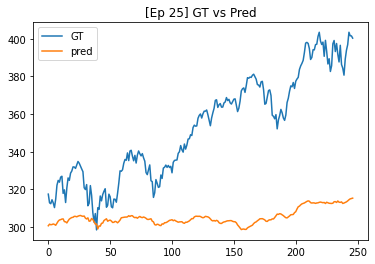

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 294.46it/s]



[EP 26] Train LOSS: 0.0383


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3399.82it/s]



[EP 26] Val LOSS: 1.4792


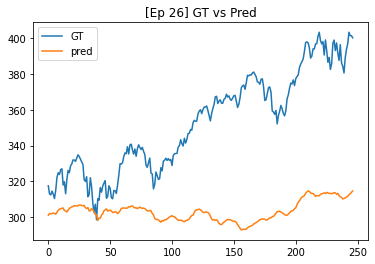

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.63it/s]



[EP 27] Train LOSS: 0.0398


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3222.64it/s]



[EP 27] Val LOSS: 1.2477


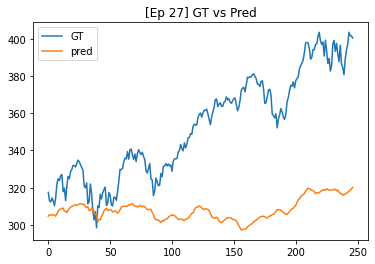

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 303.31it/s]



[EP 28] Train LOSS: 0.0396


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3383.84it/s]



[EP 28] Val LOSS: 1.4010


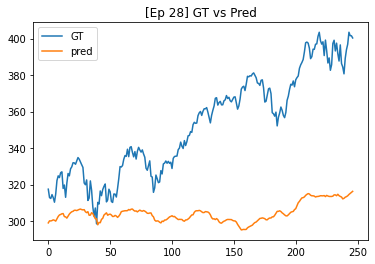

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.55it/s]



[EP 29] Train LOSS: 0.0452


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3363.66it/s]



[EP 29] Val LOSS: 1.3759


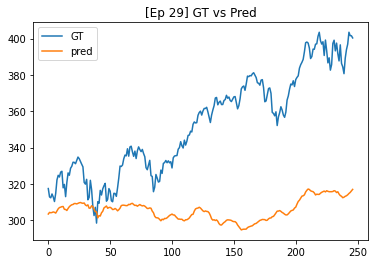

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 285.58it/s]



[EP 30] Train LOSS: 0.0484


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3327.40it/s]



[EP 30] Val LOSS: 1.1688


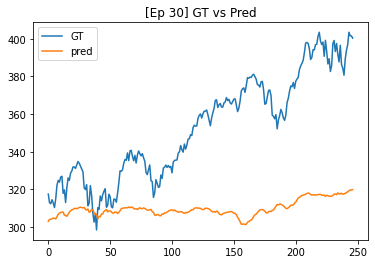

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.73it/s]



[EP 31] Train LOSS: 0.0248


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3440.74it/s]



[EP 31] Val LOSS: 1.3469


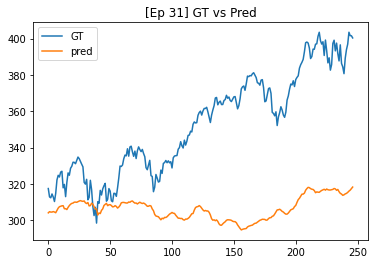

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 303.39it/s]



[EP 32] Train LOSS: 0.0387


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3391.84it/s]



[EP 32] Val LOSS: 1.2201


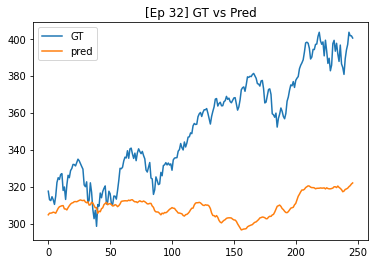

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.10it/s]



[EP 33] Train LOSS: 0.0338


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3424.33it/s]



[EP 33] Val LOSS: 1.5304


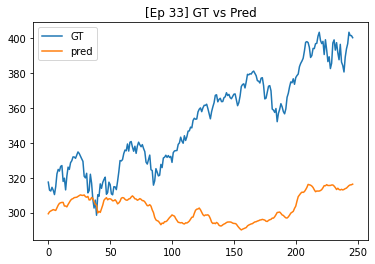

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.82it/s]



[EP 34] Train LOSS: 0.0330


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2076.71it/s]


[EP 34] Val LOSS: 1.1827


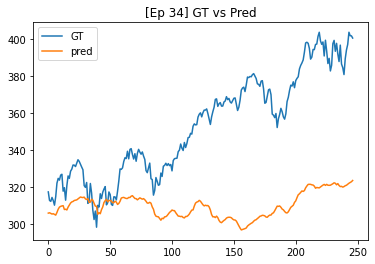

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 298.47it/s]



[EP 35] Train LOSS: 0.0358


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3310.06it/s]



[EP 35] Val LOSS: 1.3968


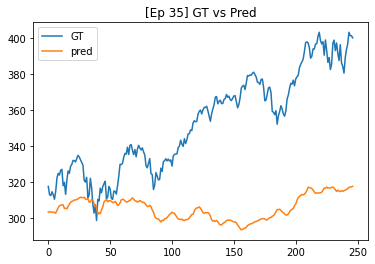

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 296.41it/s]



[EP 36] Train LOSS: 0.0397


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3250.00it/s]



[EP 36] Val LOSS: 1.5350


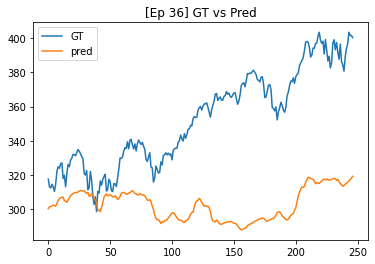

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 297.72it/s]



[EP 37] Train LOSS: 0.0327


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3344.53it/s]



[EP 37] Val LOSS: 1.5257


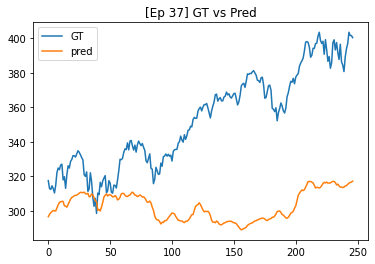

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 298.41it/s]



[EP 38] Train LOSS: 0.0338


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3284.45it/s]



[EP 38] Val LOSS: 1.3484


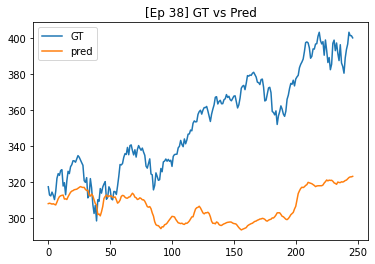

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 296.90it/s]



[EP 39] Train LOSS: 0.0311


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3465.65it/s]



[EP 39] Val LOSS: 1.5072


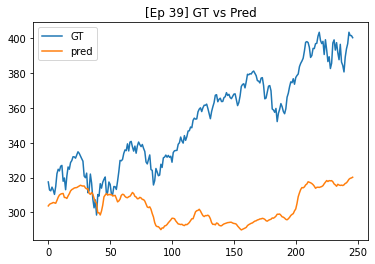

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.34it/s]



[EP 40] Train LOSS: 0.0289


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3315.61it/s]



[EP 40] Val LOSS: 1.7948


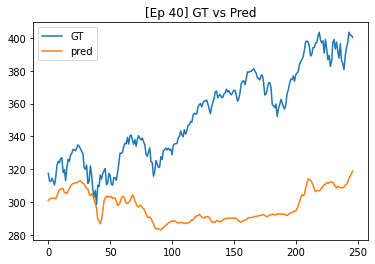

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.65it/s]



[EP 41] Train LOSS: 0.0300


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3585.12it/s]



[EP 41] Val LOSS: 1.6709


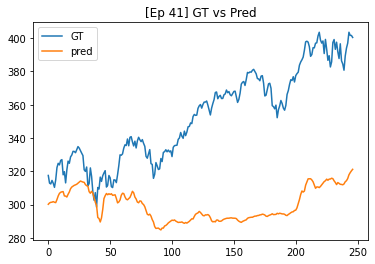

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 303.82it/s]



[EP 42] Train LOSS: 0.0279


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3491.81it/s]



[EP 42] Val LOSS: 1.8582


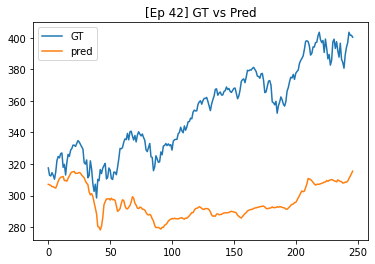

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 305.71it/s]



[EP 43] Train LOSS: 0.0371


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3550.85it/s]



[EP 43] Val LOSS: 1.9501


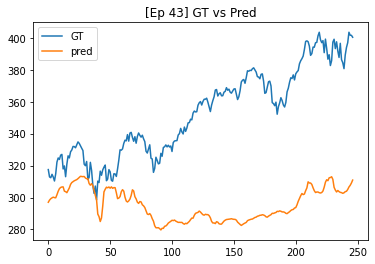

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 306.97it/s]



[EP 44] Train LOSS: 0.0372


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3385.83it/s]



[EP 44] Val LOSS: 2.5243


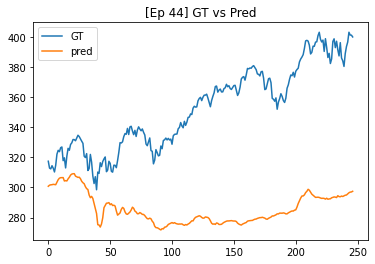

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.85it/s]



[EP 45] Train LOSS: 0.0252


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3331.85it/s]



[EP 45] Val LOSS: 2.0495


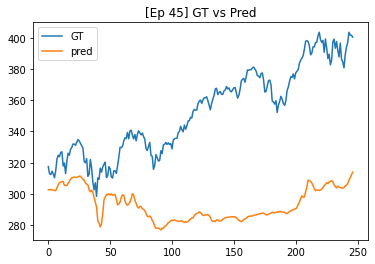

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 308.70it/s]



[EP 46] Train LOSS: 0.0295


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3485.39it/s]



[EP 46] Val LOSS: 1.6680


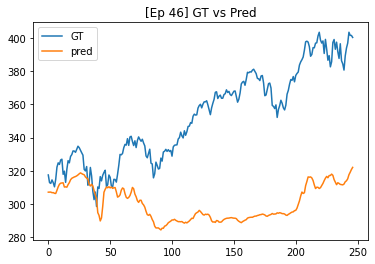

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.74it/s]



[EP 47] Train LOSS: 0.0287


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3321.98it/s]



[EP 47] Val LOSS: 1.2416


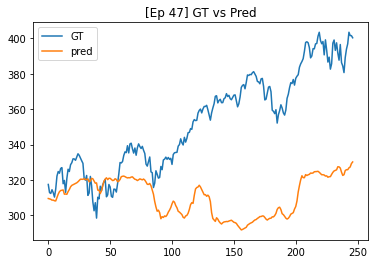

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.45it/s]



[EP 48] Train LOSS: 0.0218


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 3305.58it/s]



[EP 48] Val LOSS: 1.2790


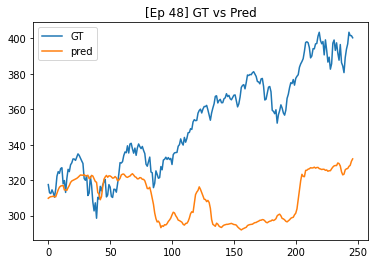

100%|██████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 303.13it/s]



[EP 49] Train LOSS: 0.0296


100%|███████████████████████████████████████████████████████| 247/247 [00:00<00:00, 2038.37it/s]


[EP 49] Val LOSS: 1.8304


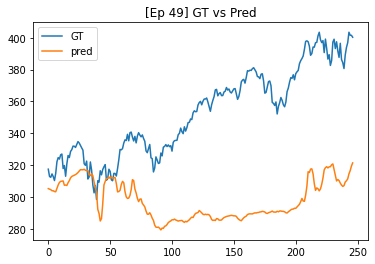

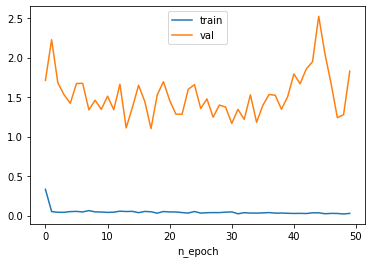

In [12]:
input_size, hidden_size, num_layers, dropout = 10, 64, 1, 0.2
net = LSTMNet(input_size, hidden_size, num_layers, dropout)
loss_fn = nn.MSELoss()
batch_size, n_epoch, lr = 32, 50, 1e-3

a = train_main(net, train_set, val_set, loss_fn, batch_size, lr, n_epoch)


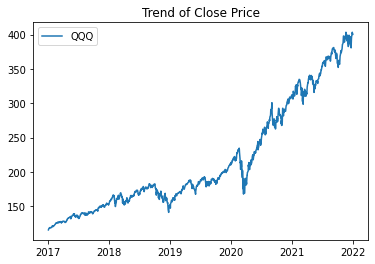

In [30]:

plt.plot(qqq_df, label='QQQ')
plt.title('Trend of Close Price')
#plt.xticks(rotation=100)
plt.legend()
plt.show()